In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Chain of Thought & ReAct

> **NOTE:** This notebook uses the PaLM generative model, which will reach its [discontinuation date in October 2024](https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/text#model_versions). Please refer to [this updated notebook](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/prompts/examples/chain_of_thought_react.ipynb) for a version which uses the latest Gemini model.

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/language/prompts/examples/chain_of_thought_react.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/prompts/examples/chain_of_thought_react.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/language/prompts/examples/chain_of_thought_react.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
</table>

<div style="clear: both;"></div>

<b>Share to:</b>

<a href="https://www.linkedin.com/sharing/share-offsite/?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/language/prompts/examples/chain_of_thought_react.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/8/81/LinkedIn_icon.svg" alt="LinkedIn logo">
</a>

<a href="https://bsky.app/intent/compose?text=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/language/prompts/examples/chain_of_thought_react.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Bluesky_Logo.svg" alt="Bluesky logo">
</a>

<a href="https://twitter.com/intent/tweet?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/language/prompts/examples/chain_of_thought_react.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/53/X_logo_2023_original.svg" alt="X logo">
</a>

<a href="https://reddit.com/submit?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/language/prompts/examples/chain_of_thought_react.ipynb" target="_blank">
  <img width="20px" src="https://redditinc.com/hubfs/Reddit%20Inc/Brand/Reddit_Logo.png" alt="Reddit logo">
</a>

<a href="https://www.facebook.com/sharer/sharer.php?u=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/language/prompts/examples/chain_of_thought_react.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/51/Facebook_f_logo_%282019%29.svg" alt="Facebook logo">
</a>            

# Introduction

This notebook demonstrates advanced prompting techniques such as chain of thought reasoning, and building [ReAct](https://arxiv.org/abs/2210.03629.pdf) agents using [LangChain](https://www.langchain.com/) and Vertex AI. You will start with exploring chain of thought, and how it can be used to improve the performance of language models. Then you will learn how to build ReAct agents using LangChain.

| | |
|----------|-------------|
| Author(s)   | [Chris Hanna](https://github.com/ChrisHanna)|

# Setup

In [ ]:
%pip install --user langchain==0.0.310 \
                    google-cloud-aiplatform==1.35.0 \
                    prettyprinter==0.18.0 \
                    wikipedia==1.4.0 \
                    chromadb==0.3.26 \
                    tiktoken==0.5.1 \
                    tabulate==0.9.0 \
                    sqlalchemy-bigquery==1.8.0 \
                    google-cloud-bigquery==3.11.4

### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

For **Vertex AI Workbench** you can also restart the terminal using the button on top

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

If you are using Colab, run the cell below to authenticate:

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()
    print("Authenticated")

## Import packages

In [ ]:
import IPython
from IPython.display import Markdown, display
from langchain.llms import VertexAI
import vertexai

In [ ]:
PROJECT_ID = "your-project-here"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}
MODEL_NAME = "text-bison"  # @param {type:"string"}

In [ ]:
vertexai.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
llm = VertexAI(model_name=MODEL_NAME, max_output_tokens=1000)

In [ ]:
llm.predict(
    "Improve this description : In this notebook we'll explore advanced prompting techniques, and building ReAct agents using LangChain and Vertex AI "
)

# Chain of Thought - Introduction

---


The technique introduced in this paper is a novel approach to enhance the reasoning capabilities of large language models (LLMs), especially in multi-step reasoning tasks.

In contrast to the standard prompting, where models are asked to directly produce the final answer, 'Chain of Thought Prompting' encourages LLMs to generate intermediate reasoning steps before providing the final answer to a problem. The advantage of this technique lies in its ability to break down complex problems into manageable, intermediate steps. By doing this, the model-generated 'chain of thought' can mimic an intuitive human thought process when working through multi-step problems.

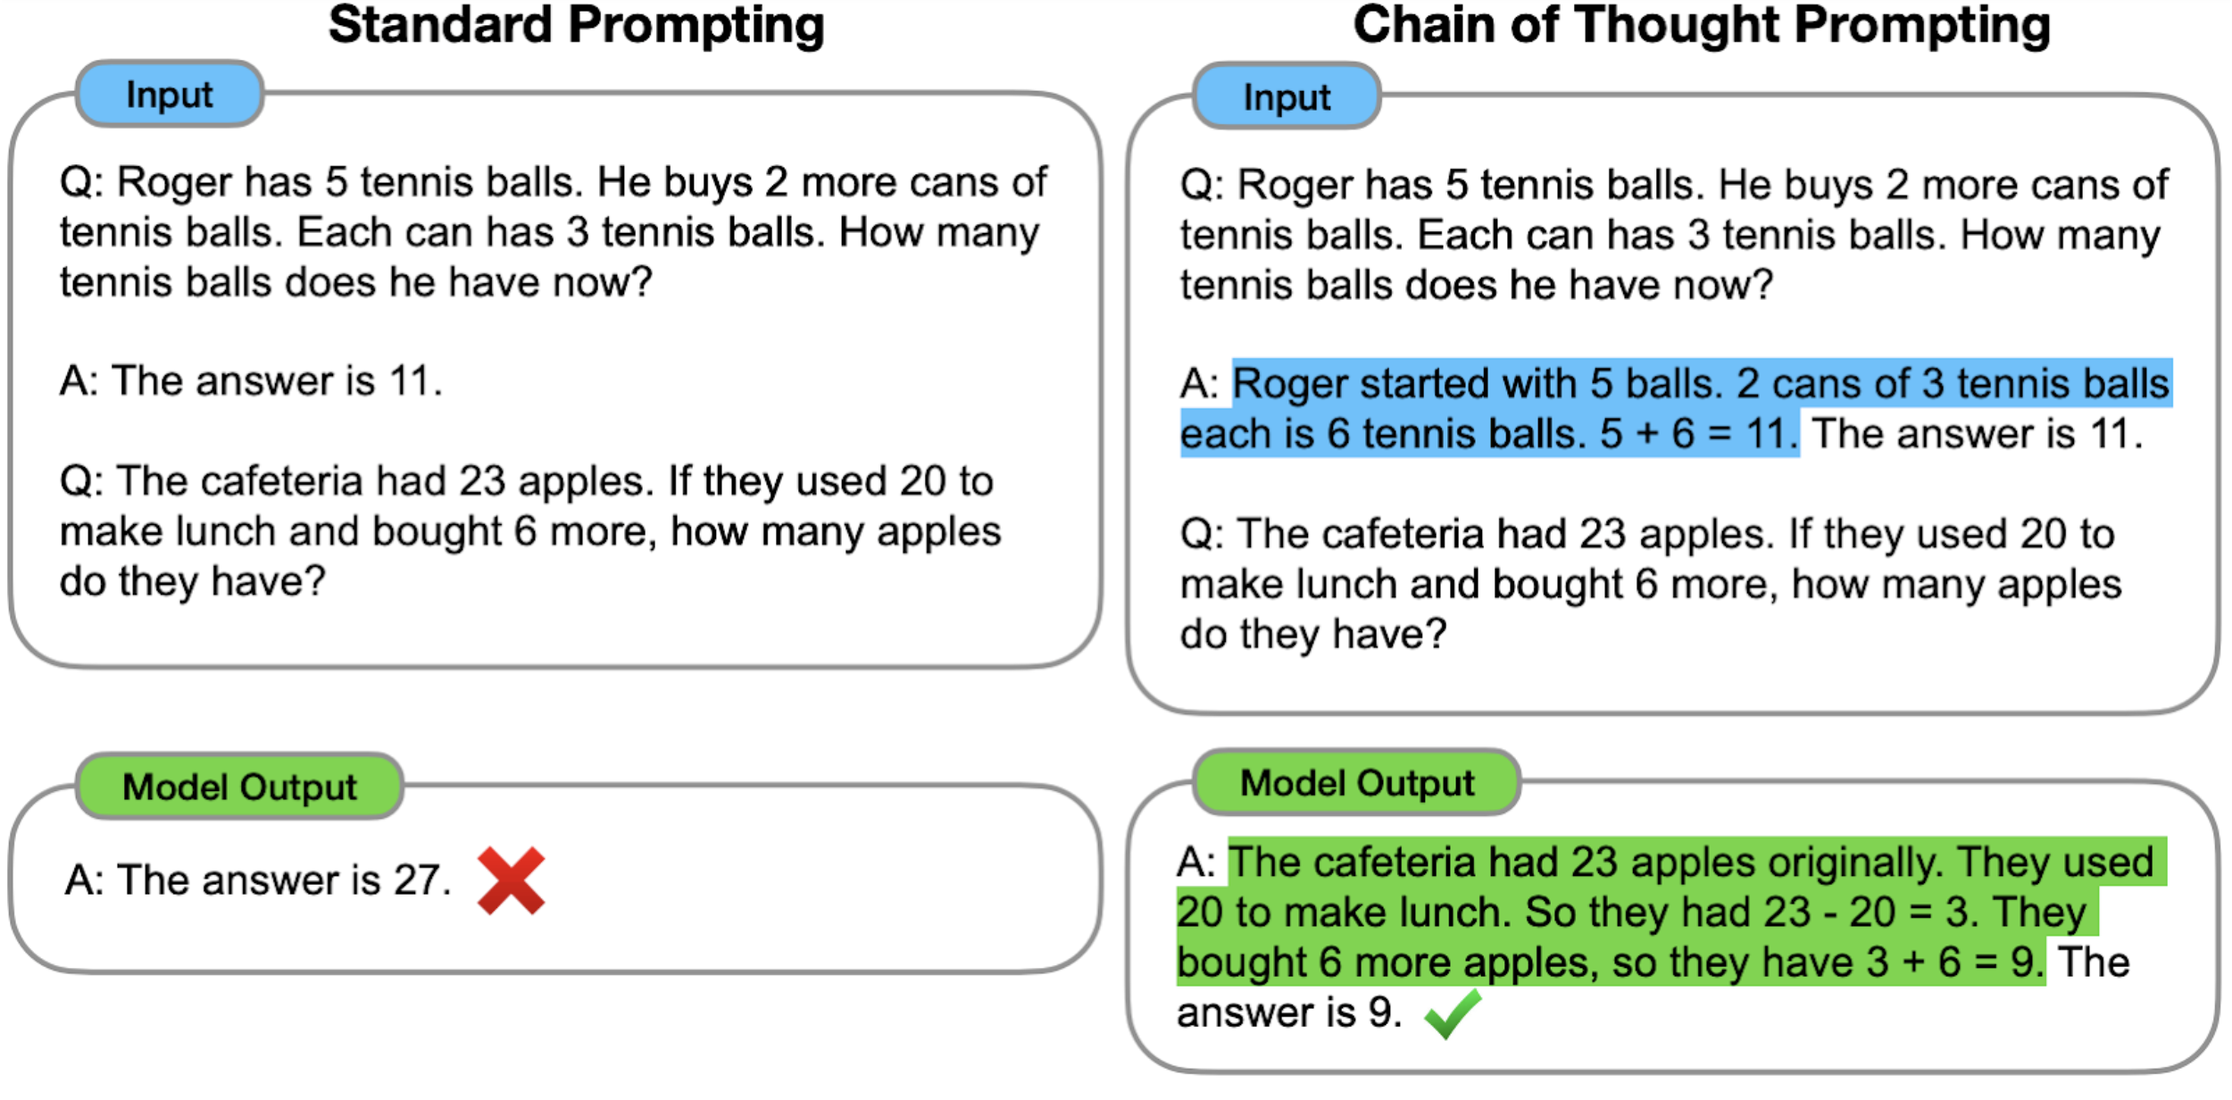

# Chain of Thought - Use Cases

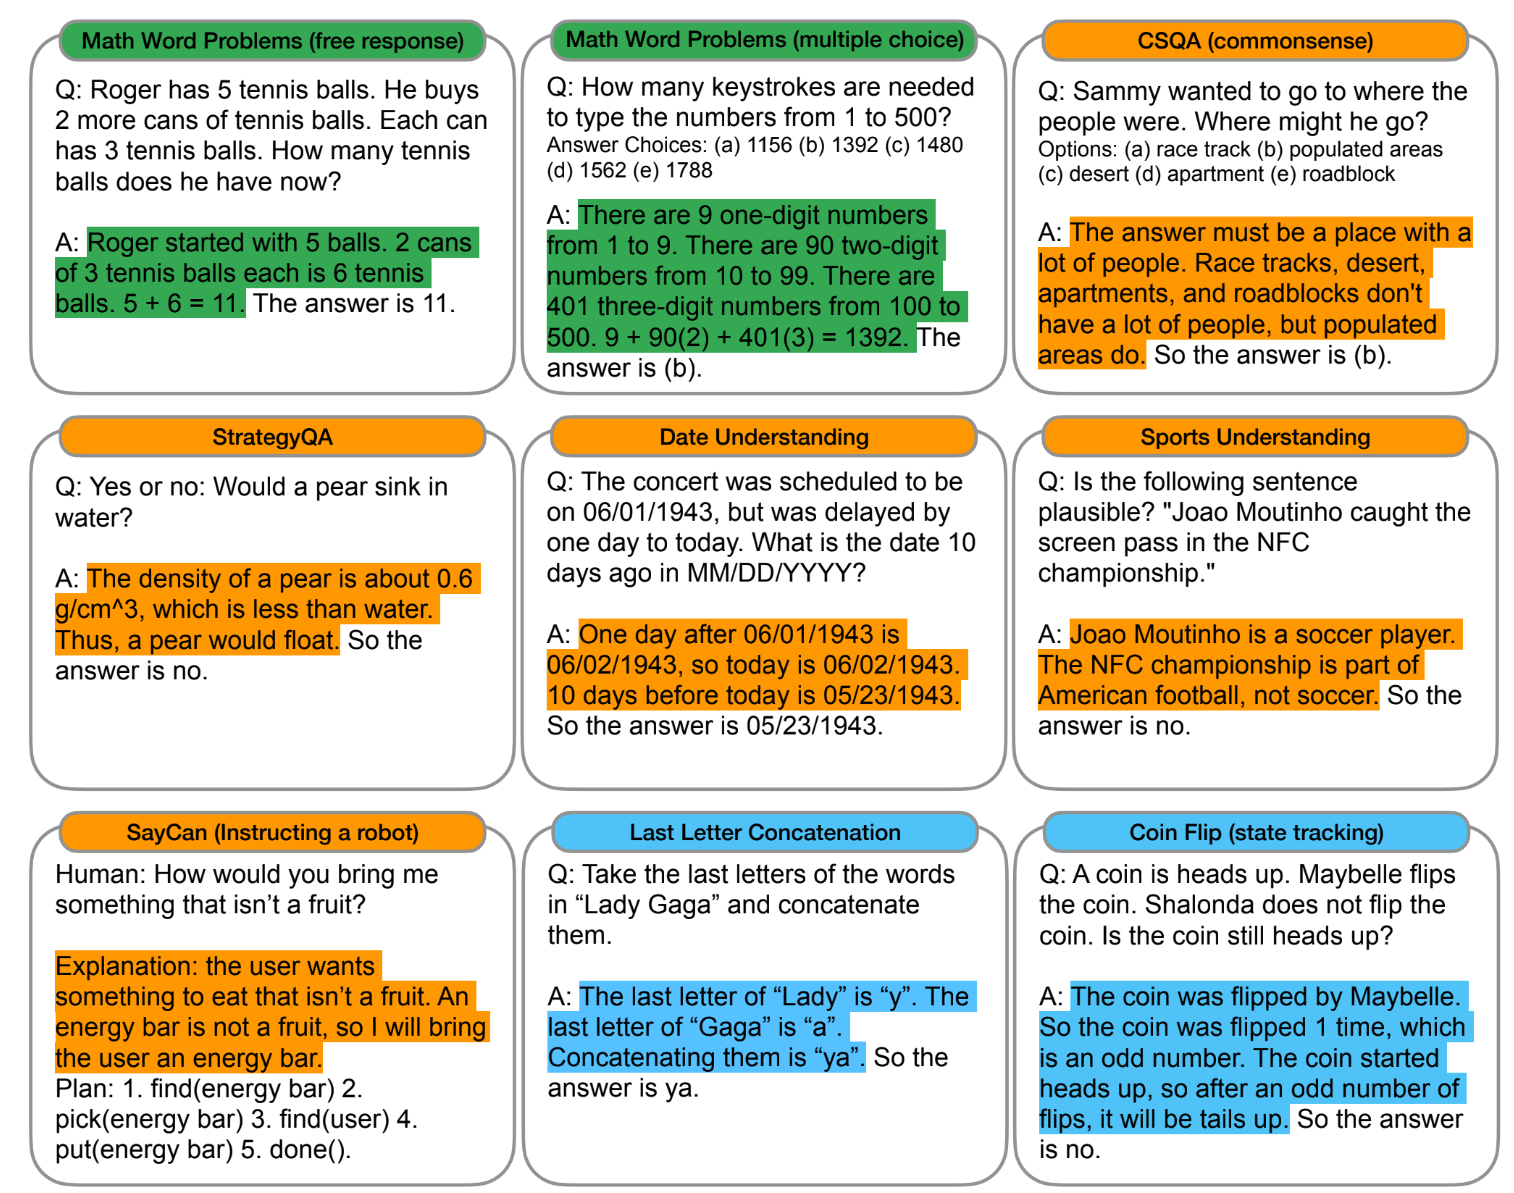


# Chain of Thought - Sample

In [ ]:
question = """Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: The answer is 11.
Q: The cafeteria had 23 apples.
If they used 20 to make lunch and bought 6 more, how many apples do they have?
A:"""

llm.predict(question)

Rewriting the prompt to include a chain of thought shows the LLM how to decompose the question into multiple simple steps of reasoning.

The model response then follows a similar chain of thought, increasing the likelihood of a correct answer.

In [ ]:
question = """Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls
each is 6 tennis balls. 5 + 6 = 11. The answer is 11.
Q: The cafeteria had 23 apples.
If they used 20 to make lunch and bought 6 more, how many apples do they have?
A:"""

llm.predict(question)

Notice the chain of thought includes both text describing the steps to follow and intermediate outputs/conclusions from each reasoning step.

# Chain of Thought - Zero Shot

Zero-shot CoT prompting is a technique that allows large language models (LLMs) to generate more accurate answers to questions. It does this by appending the words "Let's think step by step." to the end of a question. This simple prompt helps the LLM to generate a chain of thought that answers the question, from which the LLM can then extract a more accurate answer.

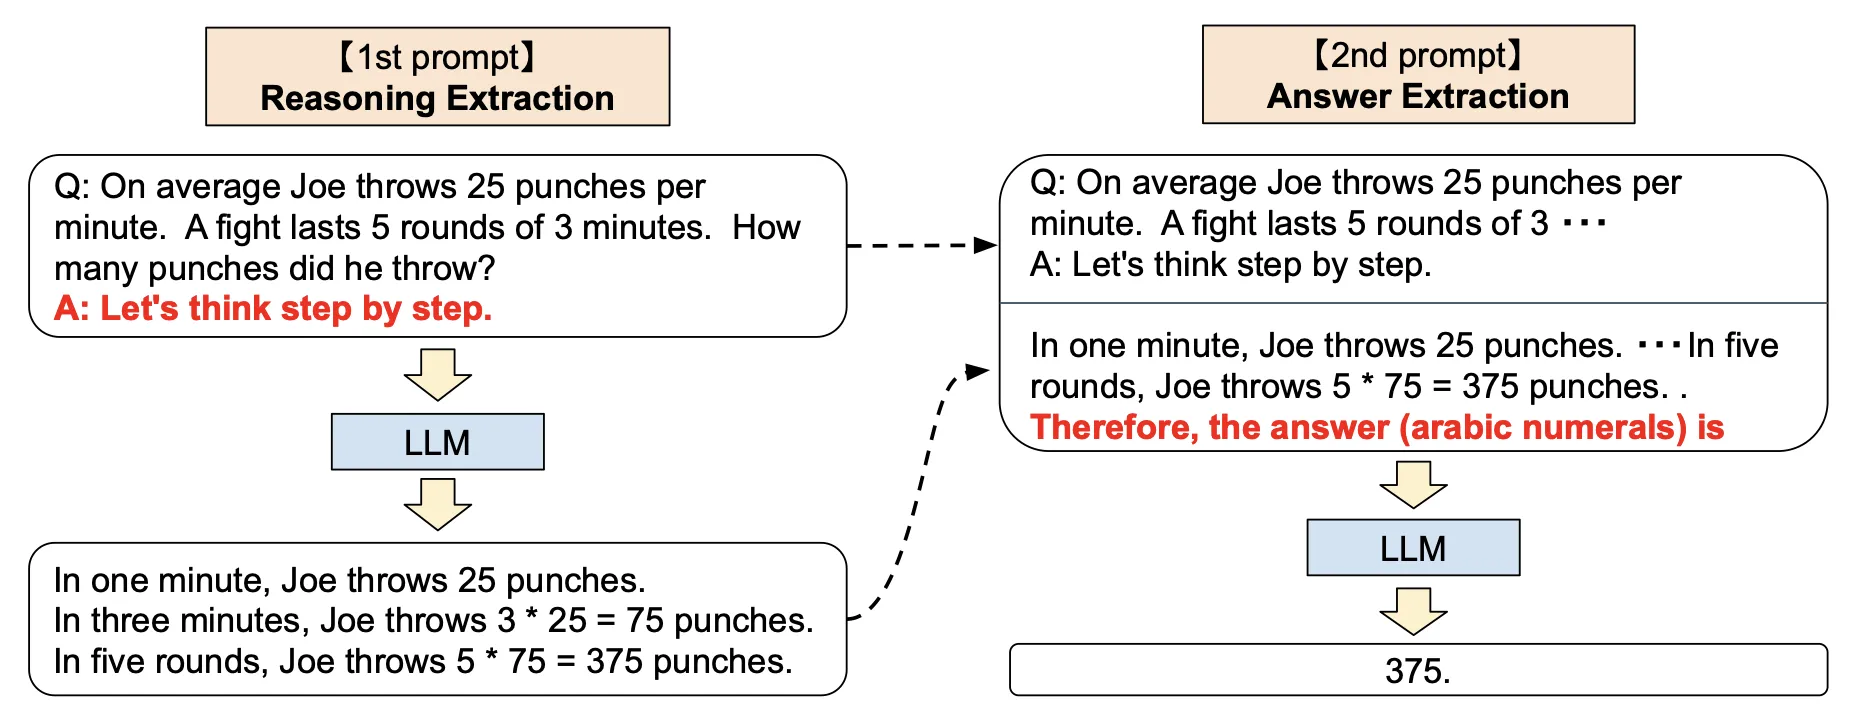

In [ ]:
question = """Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: The answer is 11.
Q: The cafeteria had 23 apples.
If they used 20 to make lunch and bought 6 more, how many apples do they have?
A:"""

llm.predict(question)

In [ ]:
question = """Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: The answer is 11.

Q: The cafeteria had 23 apples.
If they used 20 to make lunch and bought 6 more, how many apples do they have?
A: Let's think step by step."""

llm.predict(question)

# Chain of Thought - Self Consistency

An improvement upon CoT prompting is by doing CoT with self-consistency, whereby you generate multiple candidate answers through CoT with the same input.

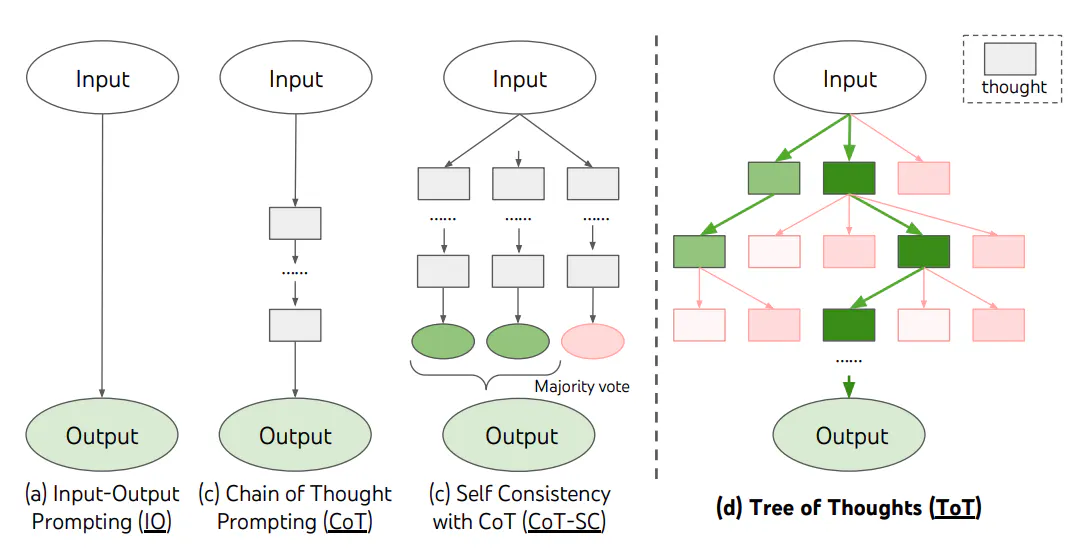

In [ ]:
from operator import itemgetter

from langchain.prompts import PromptTemplate
from langchain.schema import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

question = """The cafeteria had 23 apples.
If they used 20 to make lunch and bought 6 more, how many apples do they have?"""

context = """Answer questions showing the full math and reasoning.
Follow the pattern in the example.
"""

one_shot_exemplar = """Example Q: Roger has 5 tennis balls. He buys 2 more cans of tennis balls.
Each can has 3 tennis balls. How many tennis balls does he have now?
A: Roger started with 5 balls. 2 cans of 3 tennis balls
each is 6 tennis balls. 5 + 6 = 11.
The answer is 11.

Q: """


planner = (
    PromptTemplate.from_template(context + one_shot_exemplar + " {input}")
    | VertexAI()
    | StrOutputParser()
    | {"base_response": RunnablePassthrough()}
)

answer_1 = (
    PromptTemplate.from_template("{base_response} A: 33")
    | VertexAI(temperature=0, max_output_tokens=400)
    | StrOutputParser()
)

answer_2 = (
    PromptTemplate.from_template("{base_response} A:")
    | VertexAI(temperature=0.1, max_output_tokens=400)
    | StrOutputParser()
)

answer_3 = (
    PromptTemplate.from_template("{base_response} A:")
    | VertexAI(temperature=0.7, max_output_tokens=400)
    | StrOutputParser()
)

final_responder = (
    PromptTemplate.from_template(
        "Output all the final results in this markdown format: Result 1: {results_1} \n Result 2:{results_2} \n Result 3: {results_3}"
    )
    | VertexAI(max_output_tokens=1024)
    | StrOutputParser()
)

chain = (
    planner
    | {
        "results_1": answer_1,
        "results_2": answer_2,
        "results_3": answer_3,
        "original_response": itemgetter("base_response"),
    }
    | final_responder
)


answers = chain.invoke({"input": question})
display(Markdown(answers))

As seen in the output above, three answers were generated, but there is a most popular answer.

# Chain of Thought - JSON Data

Sample from [Advanced Prompt Engineering](https://github.com/GoogleCloudPlatform/applied-ai-engineering-samples/tree/main/assets/advanced_prompting_training) by [Michael Sherman](https://github.com/michaelwsherman) 

In [ ]:
context = """Given a JSON entry of a data source, output a JSON with the following fields and explain the reasoning:
pii: True/False, the dataset contains Personally Identifiable Information.
age: How many years since the dataset was last modified.
keywords: New keywords to index this dataset under, beyond the current set of keywords.
The last text output should be the JSON.
"""


question = """
{
    "@type" : "dcat:Dataset",
    "description" : "<p>The MDS 3.0 Frequency Report summarizes information for active residents currently in nursing homes. The source of these counts is the residents MDS assessment record. The MDS assessment information for each active nursing home resident is consolidated to create a profile of the most recent standard information for the resident.</p>\n",
    "title" : "MDS 3.0 Frequency Report",
    "accessLevel" : "public",
    "identifier" : "465",
    "license" : "http://opendefinition.org/licenses/odc-odbl/",
    "modified" : "2016-04-05",
    "temporal" : "2012-01-01T00:00:00-05:00/2015-12-31T00:00:00-05:00",
    "contactPoint" : {
      "@type" : "vcard:Contact",
      "fn" : "Health Data Initiative",
      "hasEmail" : "mailto:HealthData@hhs.gov"
    },
    "bureauCode" : [ "009:38" ],
    "keyword" : [ "Activities of Daily Living (ADL)" ],
    "language" : [ "en" ],
    "programCode" : [ "009:000" ],
    "publisher" : {
      "@type" : "org:Organization",
      "name" : "Centers for Medicare & Medicaid Services",
      "subOrganizationOf" : {
        "@type" : "org:Organization",
        "name" : "Department of Health & Human Services"
      }
    }
  }


"""

llm_prompt = f"{context}\nJSON:{question}\nAnswer:"

display(Markdown(llm.predict(llm_prompt)))

As seen in the output above, the JSON formatting is correct, but age is incorrect, and no keywords were extracted. 

To improve the response quality, you can add one exemplar, which should lead to a correct response:

In [ ]:
one_shot_example = """
JSON:
{

    "@type" : "dcat:Dataset",
    "description" : "The primary purpose of this system of records is to properly pay medical insurance benefits to or on behalf of entitled beneficiaries.",
    "title" : "Medicare Multi-Carrier Claims System",
    "accessLevel" : "restricted public",
    "dataQuality" : true,
    "identifier" : "b6ffafab-1cfd-42dd-b8cb-7a554efaefa7",
    "landingPage" : "http://www.cms.gov/Research-Statistics-Data-and-Systems/Computer-Data-and-Systems/Privacy/Systems-of-Records-Items/09-70-0501-MCS.html",
    "license" : "http://www.usa.gov/publicdomain/label/1.0/",
    "modified" : "2014-09-30",
    "rights" : "Contains personally identifiable information and is subject to the Privacy Act of 1974, as amended at 5 United States Code (U.S.C.) 552a.  Requests should be directed to the appropriate System Manager, identified in the System of Records notice.",
    "primaryITInvestmentUII" : "009-000004256, 009-000004254",
    "systemOfRecords" : "09-70-0501",

    "contactPoint" : {
      "@type" : "vcard:Contact",
      "fn" : "Health Data Initiative",
      "hasEmail" : "mailto:Healthdata@hhs.gov"
    },
    "bureauCode" : [ "009:38" ],
    "keyword" : [ "medicare", "part b", "claims" ],
    "programCode" : [ "009:078" ],
    "theme" : [ "Medicare" ],
    "publisher" : {
      "@type" : "org:Organization",
      "name" : "Centers for Medicare & Medicaid Services",
      "subOrganizationOf" : {
        "@type" : "org:Organization",
        "name" : "Department of Health & Human Services"
      }
    }
  }

Answer: The 'rights' tag says 'Contains personally identifiable information' so pii is True.
The 'modified' tag is '2014-09-30'. The current year is 2023, 2023 minus 2014 is 9, so the age is 9.
To determine keywords I will look at all the fields that describe the dataset.
Then I will take the most salient and distinctive aspects of the fields and make those keywords.
Looking at all the fields, the ones that describe the dataset are  "description" and "title".
The "title" field is "Medicare Multi-Carrier Claims System".
Good keywords from the "title" field are "medicare" and "claims".
The "description" field is ""The primary purpose of this system of records is to properly pay medical insurance benefits to or on behalf of entitled beneficiaries."
Good keywords from the "description" field are "medical insurance benefits".
Good proposed keywords from both fields are "medicare", "claims", and "medical insurance benefits".
Next inspect the "keyword" field to make sure the proposed keywords are not already included.
The "keyword" field contains the keywords "medicare", "part b", and "claims".
From our proposed keywords, "medicare" should not be output since it is already in the "keyword" field.
That leaves "claims" and "medical insurance benefits" as proposed keywords.

Output JSON:
{
  "pii" : true,
  "age" : 9,
  "keywords" : ["claims", "medical insurance benefits"]
}
"""

# Prepending the one shot exemplar before the question we want answered.
llm_prompt = f"{context}{one_shot_example}\nJSON:{question}\nAnswer:"

display(Markdown(llm.predict(llm_prompt)))

# ReAct - Introduction


[ReAct](https://arxiv.org/abs/2210.03629.pdf) (short for Reasoning & Acting) combines chain of thought and tool usage together to reason through complex tasks by interacting with external systems. ReAct is particularly useful if you want the LLM or an LLM-based chatbot to reason and take action on external systems through extensions.

For example, LLMs do not know today's date:

In [ ]:
llm("What is today's date?")

But you can easily create a Python function to fetch today's date:

In [ ]:
def get_current_date():
    """
    Gets the current date (today), in the format YYYY-MM-DD
    """

    from datetime import datetime

    todays_date = datetime.today().strftime("%Y-%m-%d")

    return todays_date

To enable the LLM to use this function, you can use tools with a ReAct agent:

In [ ]:
from langchain.agents import AgentType, initialize_agent, load_tools
from langchain.llms import VertexAI
from langchain.tools import StructuredTool, WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
import vertexai

t_get_current_date = StructuredTool.from_function(get_current_date)

tools = [
    t_get_current_date,
]

agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
)

In [ ]:
agent.run("What's today's date?")

# ReAct - Wikipedia

In the example below, you can enable the LLM the check Wikipedia:

In [ ]:
llm = VertexAI(temperature=0)

_ = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

tools = load_tools(["wikipedia"], llm=llm)

tools.append(t_get_current_date)

agent = initialize_agent(
    tools,
    llm,
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
)

# agent.run("What former US President was first?")
agent.run(
    "Fetch today's date, and tell me which famous person was born or who died on the same day as today?"
)

# ReAct - BigQuery

In [ ]:
from collections.abc import Sequence
from typing import Any

from google.cloud import bigquery
from langchain.agents import AgentExecutor, Tool, initialize_agent
from langchain.agents.agent import Agent, AgentOutputParser
from langchain.agents.react.output_parser import ReActOutputParser
from langchain.llms import VertexAI
from langchain.output_parsers import CommaSeparatedListOutputParser
from langchain.prompts.base import BasePromptTemplate
from langchain.prompts.prompt import PromptTemplate
from langchain.tools.base import BaseTool
from langchain.tools.python.tool import PythonREPLTool

bq = bigquery.Client(project=PROJECT_ID)
llm = VertexAI(temperature=0, max_tokens=1024)

Define custom tools

In [ ]:
def get_comment_by_id(id: str) -> str:
    QUERY = "SELECT text FROM bigquery-public-data.hacker_news.full WHERE ID = {id} LIMIT 1".format(
        id=id
    )
    df = bq.query(QUERY).to_dataframe()

    return df


def get_comment_by_user(user):
    QUERY = "SELECT text FROM bigquery-public-data.hacker_news.full WHERE `BY` = {user} LIMIT 10".format(
        user=user
    )
    df = bq.query(QUERY).to_dataframe()

    return df


def generate_response_for_comment(comment):
    question = """Create a 1 sentence friendly response to the following comment: {comment}""".format(
        comment=comment
    )
    llm1 = VertexAI(temperature=0.3, max_output_tokens=150)
    response = llm1.predict(question)

    return response


def generate_sentiment_for_comment(comment):
    question = """What is the sentiment of the comment (Negative, Positive, Neutral): {comment}""".format(
        comment=comment
    )
    llm1 = VertexAI(temperature=0.3, max_output_tokens=150)
    response = llm1.predict(question)

    return response


def generate_category_for_comment(comment):
    question = """Put the comment into one of these categories (Technology, Politics, Products, News): {comment}""".format(
        comment=comment
    )
    llm1 = VertexAI(temperature=0.3, max_output_tokens=150)
    response = llm1.predict(question)

    return response

In [ ]:
tools = [
    Tool(
        name="GetCommentsById",
        func=get_comment_by_id,
        description="Get a pandas dataframe of comment by id.",
    ),
    Tool(
        name="GetCommentsByUser",
        func=get_comment_by_user,
        description="Get a pandas dataframe of comments by user.",
    ),
    Tool(
        name="GenerateCommentResponse",
        func=generate_response_for_comment,
        description="Get an AI response for the user comment.",
    ),
    Tool(
        name="GenerateCommentSentiment",
        func=generate_sentiment_for_comment,
        description="Get an AI sentiment for the user comment.",
    ),
    Tool(
        name="GenerateCategorySentiment",
        func=generate_category_for_comment,
        description="Get an AI category for the user comment.",
    ),
    PythonREPLTool(),
]

Setup Prompt and Examples

In [ ]:
EXAMPLES = [
    """Question: Write a response to the following Comment 1234 ?
Thought: I need to get comment 1234 using GetCommentsById.
Action: GetCommentsById[1234]
Observation: "Comment Text"
Thought: I need to generate a response to the comment.
Action: GenerateCommentResponse["Comment Text"]
Observation: LLM Generated response
Thought: So the answer is "LLM Generated response".
Action: Finish["LLM Generated response"],
Question: Write a response to all the comments by user xx234 ?
Thought: I need to get all the comments by xx234 using GetCommentsByUser.
Action: GetCommentsByUser['xx234']
Observation: "Comment Text"
Thought: I need to generate a response to each comment.
Action: GenerateCommentResponse["Comment Text 1"]
Observation: "LLM Generated response 1"
Thought: I need to generate a response to each comment.
Action: GenerateCommentResponse["Comment Text 2"]
Observation: "LLM Generated response 2"
Thought: I need to generate a response to each comment.
Action: GenerateCommentResponse["Comment Text 3"]
Observation: "LLM Generated response 3"
Thought: I Generated responses for all the comments.
Action: Finish["Done"],
Question: Sentiment for all the comments by user xx234 ?
Thought: I need to get all the comments by xx234 using GetCommentsByUser.
Action: GetCommentsByUser['xx234']
Observation: "Comment Text"
Thought: I need to determine sentiment of each comment.
Action: GenerateCommentSentiment["Comment Text 1"]
Observation: "LLM Generated Sentiment 1"
Thought: I need to determine sentiment of each comment.
Action: GenerateCommentSentiment["Comment Text 2"]
Observation: "LLM Generated Sentiment 2"
Thought: I need to generate a response to each comment.
Action: GenerateCommentSentiment["Comment Text 3"]
Observation: "LLM Generated Sentiment 3"
Thought: I determined sentiment for all the comments.
Action: Finish["Done"],
Question: Category for all the comments by user xx234 ?
Thought: I need to get all the comments by xx234 using GetCommentsByUser.
Action: GetCommentsByUser['xx234']
Observation: "Comment Text"
Thought: I need to determine the category of each comment.
Action: GenerateCategorySentiment["Comment Text 1"]
Observation: "LLM Generated Category 1"
Thought: I need to determine category of each comment.
Action: GenerateCategorySentiment["Comment Text 2"]
Observation: "LLM Generated Category 2"
Thought: I need to generate a category to each comment.
Action: GenerateCategorySentiment["Comment Text 3"]
Observation: "LLM Generated Category 3"
Thought: I determined Category for all the comments.
Action: Finish["Done"]
"""
]

SUFFIX = """\nIn each action, you cannot use the nested functions, such as GenerateCommentResponse[GetCommentsByUser["A"], GetCommentsById["B"]].
Instead, you should parse into 3 actions - GetCommentsById['A'], GetCommentsByUser['B'], and GenerateCommentResponse("Comment").

Let's start.

Question: {input}
{agent_scratchpad} """

output_parser = CommaSeparatedListOutputParser()

format_instructions = output_parser.get_format_instructions()

TEST_PROMPT = PromptTemplate.from_examples(
    examples=EXAMPLES,
    suffix=SUFFIX,
    input_variables=["input", "agent_scratchpad"],
)


class ReActTestAgent(Agent):
    @classmethod
    def _get_default_output_parser(cls, **kwargs: Any) -> AgentOutputParser:
        return ReActOutputParser()

    @classmethod
    def create_prompt(cls, tools: Sequence[BaseTool]) -> BasePromptTemplate:
        return TEST_PROMPT

    @classmethod
    def _validate_tools(cls, tools: Sequence[BaseTool]) -> None:
        if len(tools) != 6:
            raise ValueError("The number of tools is invalid.")
        tool_names = {tool.name for tool in tools}
        if tool_names != {
            "GetCommentsById",
            "GetCommentsByUser",
            "GenerateCommentResponse",
            "GenerateCommentSentiment",
            "GenerateCategorySentiment",
            "Python_REPL",
        }:
            raise ValueError("The name of tools is invalid.")

    @property
    def _agent_type(self) -> str:
        return "react-test"

    @property
    def finish_tool_name(self) -> str:
        return "Final Answer: "

    @property
    def observation_prefix(self) -> str:
        return f"Observation: "

    @property
    def llm_prefix(self) -> str:
        return f"Thought: "

In [ ]:
llm = VertexAI(
    temperature=0,
)

agent = ReActTestAgent.from_llm_and_tools(llm, tools, verbose=True)

agent_executor = AgentExecutor.from_agent_and_tools(
    agent=agent, tools=tools, verbose=True
)
agent_executor.handle_parsing_errors = True

In [ ]:
input = "Get the category for comment 8885404"
agent_executor.run(input)

In [ ]:
input = "Get the sentiment for comment 8885404"
agent_executor.run(input)

In [ ]:
input = "Get a response for comment 8885404"
agent_executor.run(input)

In [ ]:
input = "Get the sentiment for all the to comments written by chris"
agent_executor.run(input)

In [ ]:
input = "Get the category for all the to comments written by chris"
agent_executor.run(input)

In [ ]:
input = "Get the response for all the to comments written by chris."
agent_executor.run(input)